In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ast
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from statistics import mean
from utils import *
sns.set_theme()
import ast
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from statistics import mean


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
stateful_df = pd.read_csv("Data/Prepared Data/stateful.csv")
stateless_df = pd.read_csv("Data/Prepared Data/stateless.csv")
stateless_df = stateless_df.fillna("")

# Stateless Model - Reimplementation

Train Accuracy: 0.7530325140978065
Test Accuracy: 0.7526594164140964
Total time elapsed for prediction: 18.93
Train Accuracy: 0.7570427010956322
Test Accuracy: 0.736711084111409
Total time elapsed for prediction: 20.49
Train Accuracy: 0.7505682859307756
Test Accuracy: 0.7625031365143091
Total time elapsed for prediction: 18.74
Train Accuracy: 0.7502265715148844
Test Accuracy: 0.763962441066547
Total time elapsed for prediction: 17.18
Train Accuracy: 0.7541422555462561
Test Accuracy: 0.7483459014011965
Total time elapsed for prediction: 16.40


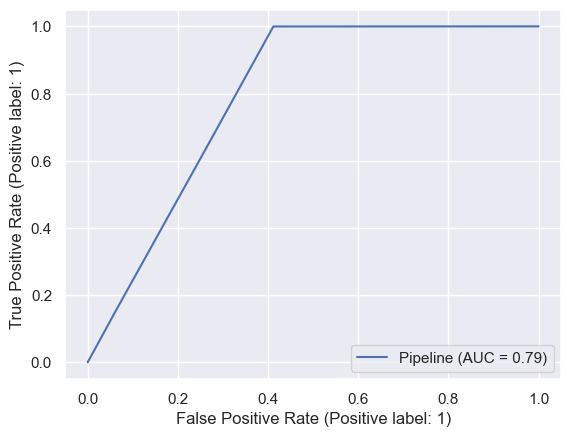

In [4]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type", "original_index", \
                                "entropy", "labels_max", "len", "subdomain"]]]
y = stateless_df["attack"]
trained_pipes_rf = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('rf', RandomForestClassifier(random_state=0))
    ])    
    pipe.fit(X_train, y_train)
    
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    prediction_time_end = time.time()
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateless += (prediction_time_end - prediction_time_start)
    trained_pipes_rf.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    
rf_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    


In [5]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 91.743
Time to evaluate a single data point: 0.00012116


## Overall Results

In [6]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999572,0.595908,0.746676,462858.000000
1,0.611369,0.999599,0.758704,294353.000000
accuracy,0.752836,0.752836,0.752836,0.752836
macro avg,0.805471,0.797754,0.752690,757211.000000
weighted avg,0.848665,0.752836,0.751352,757211.000000


## Light-attack

In [7]:
temp = stateless_df[(stateless_df["origin"]=="light-attack")
                  | (stateless_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999699,0.608677,0.756656,60091.00000
1,0.644719,0.999742,0.783907,42683.00000
accuracy,0.771090,0.771090,0.771090,0.77109
macro avg,0.822209,0.804210,0.770282,102774.00000
weighted avg,0.852273,0.771090,0.767974,102774.00000


## Heavy-attack

In [8]:
temp = stateless_df[(stateless_df["origin"]=="heavy-attack")
                  | (stateless_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999021,0.601253,0.750702,181694.000000
1,0.776398,0.999575,0.873964,251670.000000
accuracy,0.832573,0.832573,0.832573,0.832573
macro avg,0.887710,0.800414,0.812333,433364.000000
weighted avg,0.869736,0.832573,0.822284,433364.000000


In [9]:
stateless_df.Predictions.value_counts(normalize=False)

1    481272
0    275939
Name: Predictions, dtype: int64

# Stateful Model Reimplementation

In [10]:
stateful_df.columns

Index(['rr', 'A_frequency', 'NS_frequency', 'CNAME_frequency', 'SOA_frequency',
       'NULL_frequency', 'PTR_frequency', 'HINFO_frequency', 'MX_frequency',
       'TXT_frequency', 'AAAA_frequency', 'SRV_frequency', 'OPT_frequency',
       'rr_type', 'rr_count', 'rr_name_entropy', 'rr_name_length',
       'distinct_ns', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'a_records', 'unique_ttl',
       'ttl_mean', 'ttl_variance', 'original_index', 'data_type', 'attack',
       'origin'],
      dtype='object')

Train Accuracy: 0.7993790656416322
Test Accuracy: 0.8063371549569829
Total time elapsed for prediction: 8.87
Train Accuracy: 0.8036330859769939
Test Accuracy: 0.7898742870223765
Total time elapsed for prediction: 8.48
Train Accuracy: 0.7999799698594074
Test Accuracy: 0.803361248354667
Total time elapsed for prediction: 8.39
Train Accuracy: 0.8006047194826501
Test Accuracy: 0.8018923713778829
Total time elapsed for prediction: 8.25
Train Accuracy: 0.8020497510539669
Test Accuracy: 0.7958833292001297
Total time elapsed for prediction: 9.61


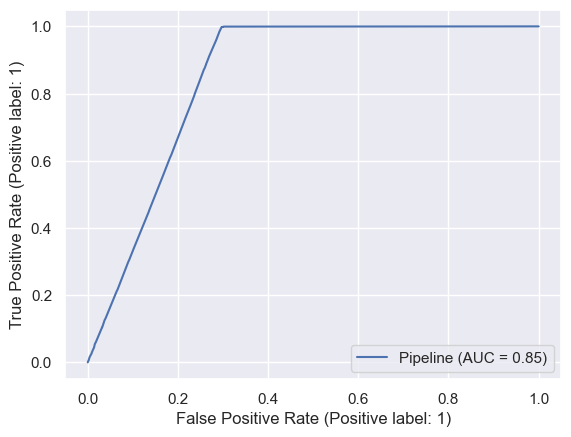

In [11]:
stateful_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
categorical_features = ["rr_type", "distinct_ip", "unique_country",
"unique_asn", "distinct_domains", "reverse_dns"]
X = stateful_df[[col for col in stateful_df.columns if col not in ["unique_ttl", "attack", "origin", "data_type", "original_index"]]]
y = stateful_df["attack"]
trained_pipes_rf = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateful = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
     ('scaler', StandardScaler(), [col for col in X_train if col not in categorical_features])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('rf', RandomForestClassifier(random_state=0))
    ])
    pipe.fit(X_train, y_train)
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateful_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    prediction_time_end = time.time()
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateful += (prediction_time_end - prediction_time_start)
    
    trained_pipes_rf.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    #display(pd.DataFrame(classification_report(y_test, pipe.predict(X_test), output_dict=True)).T)
rf_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    



In [12]:
print(f"Total prediction time for {stateful_df.shape[0]} rows is {total_prediction_time_stateful:.3f}")
single_datapoint_evaluation_time_stateful = total_prediction_time_stateful/stateful_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateful:.8f}")

Total prediction time for 262105 rows is 43.597
Time to evaluate a single data point: 0.00016634


## Overall Results

In [13]:
display(pd.DataFrame(classification_report(stateful_df["attack"], stateful_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.992478,0.711403,0.828757,178782.00000
1,0.614826,0.988431,0.758098,83323.00000
accuracy,0.799470,0.799470,0.799470,0.79947
macro avg,0.803652,0.849917,0.793427,262105.00000
weighted avg,0.872422,0.799470,0.806294,262105.00000


## Light Attack Results

In [14]:
temp = stateful_df[(stateful_df["origin"]=="light-attack")
                  | (stateful_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.988494,0.713150,0.828545,22768.000000
1,0.629699,0.983267,0.767731,11295.000000
accuracy,0.802718,0.802718,0.802718,0.802718
macro avg,0.809096,0.848208,0.798138,34063.000000
weighted avg,0.869521,0.802718,0.808380,34063.000000


## Heavy Attack Results

In [15]:
temp = stateful_df[(stateful_df["origin"]=="heavy-attack")
                  | (stateful_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.984441,0.710487,0.825324,69016.00000
1,0.780992,0.989240,0.872867,72028.00000
accuracy,0.852840,0.852840,0.852840,0.85284
macro avg,0.882716,0.849864,0.849096,141044.00000
weighted avg,0.880544,0.852840,0.849603,141044.00000


In [16]:
stateful_df.origin.value_counts()

only-benign     86998
heavy-attack    72028
heavy-benign    69016
light-benign    22768
light-attack    11295
Name: origin, dtype: int64

# Two-step model

In [17]:
WINDOW_SIZE=100
SUSPICIOUS_THRESHOLD = 0.4
ATTACK_THRESHOLD = 0.7

In [18]:
def two_step(stateless_df, stateful_df, is_light=True):
    estimated_time = 0
       
    if is_light:
        light_or_heavy_string = "light"
    else:
        light_or_heavy_string = "heavy"
        
    stateless_df_subset = stateless_df[stateless_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateless_df_subset["Final_two_step_prediction"] = stateless_df_subset["Predictions"]
    stateful_df_subset = stateful_df[stateful_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateful_df_subset["Final_two_step_prediction"] = stateful_df_subset["Predictions"] 
    stateful_df_subset['unique_ttl'] = stateful_df_subset['unique_ttl'].apply(ast.literal_eval)
    stateful_df_subset = stateful_df_subset.explode("unique_ttl")

    time_windows = []
    attack_ratios = []

    for i in range(0, stateless_df_subset.shape[0], WINDOW_SIZE):
        current_data = stateless_df_subset.iloc[i:i+WINDOW_SIZE]
        attack_ratio = (current_data[current_data["Predictions"]==1].shape[0]/current_data.shape[0])
        time_windows.append(i)
        attack_ratios.append(attack_ratio)
        estimated_time += (single_datapoint_evaluation_time_stateless * WINDOW_SIZE)
        if attack_ratio >= ATTACK_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
        elif attack_ratio < SUSPICIOUS_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0
        else:
            estimated_time += (single_datapoint_evaluation_time_stateful * WINDOW_SIZE)
            stateful_data_window = stateful_df_subset.iloc[i:i+WINDOW_SIZE]
            stateful_attack_ratio = (stateful_data_window[stateful_data_window["Predictions"]==1].shape[0]/stateful_data_window.shape[0])
            if stateful_attack_ratio >= 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
            elif stateful_attack_ratio < 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0

    plt.plot(time_windows, attack_ratios)
    plt.title("Stateless attack ratio over the 100-datapoint windows")
    plt.show()
    display(pd.DataFrame(classification_report(stateless_df_subset["attack"], stateless_df_subset["Final_two_step_prediction"], output_dict=True)).T)
    print("Total Estimated Time: ", estimated_time)

## Light attack

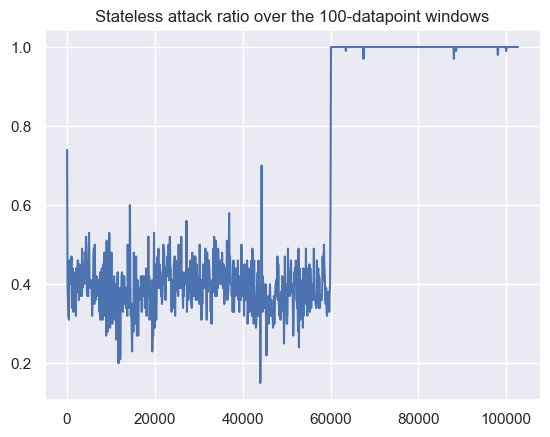

,precision,recall,f1-score,support
0,1.000000,0.948561,0.973602,60091.000000
1,0.932473,1.000000,0.965056,42683.000000
accuracy,0.969924,0.969924,0.969924,0.969924
macro avg,0.966236,0.974281,0.969329,102774.000000
weighted avg,0.971955,0.969924,0.970053,102774.000000


Total Estimated Time:  17.129190444512446


In [19]:
two_step(stateless_df, stateful_df, is_light=True)

## Heavy attack

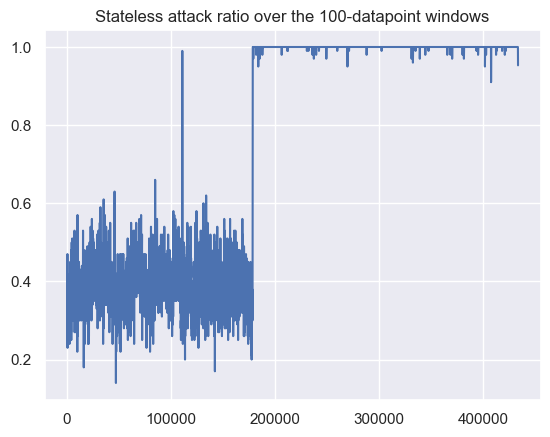

,precision,recall,f1-score,support
0,1.000000,0.939492,0.968802,181694.000000
1,0.958144,1.000000,0.978625,251670.000000
accuracy,0.974631,0.974631,0.974631,0.974631
macro avg,0.979072,0.969746,0.973713,433364.000000
weighted avg,0.975693,0.974631,0.974506,433364.000000


Total Estimated Time:  65.26833832105483


In [20]:
two_step(stateless_df, stateful_df, is_light=False)

Some potentially useful libraries we could use:
https://github.com/irvinhomem/TunnelFeatureExtractor
https://github.com/lucadivit/Pcap_Features_Extraction

# Using RFE to select Features for the Stateless Model

In [21]:
stateless_df["Predictions"] = 0
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type", "original_index"]]]

enc = OrdinalEncoder()
X[["longest_word","sld"]] = enc.fit_transform(X[["longest_word","sld"]])

y = stateless_df["attack"]

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
rfe.fit(X, y)

for i, col in zip(range(X.shape[1]), X.columns):
    print(f"{col} selected={rfe.support_[i]} rank={rfe.ranking_[i]}")

FQDN_count selected=True rank=1
subdomain_length selected=True rank=1
upper selected=True rank=1
lower selected=True rank=1
numeric selected=True rank=1
entropy selected=False rank=3
special selected=True rank=1
labels selected=True rank=1
labels_max selected=False rank=5
labels_average selected=True rank=1
longest_word selected=True rank=1
sld selected=True rank=1
len selected=False rank=4
subdomain selected=False rank=2
Predictions selected=False rank=6


Train Accuracy: 0.7529285138865044
Test Accuracy: 0.752652813269679
Total time elapsed for prediction: 18.76
Train Accuracy: 0.7569519074102504
Test Accuracy: 0.7366582586072555
Total time elapsed for prediction: 17.53
Train Accuracy: 0.7505022541595889
Test Accuracy: 0.7623578663778873
Total time elapsed for prediction: 17.30
Train Accuracy: 0.7501522857722993
Test Accuracy: 0.763889805998336
Total time elapsed for prediction: 19.55
Train Accuracy: 0.7540663190093914
Test Accuracy: 0.7481940280767555
Total time elapsed for prediction: 21.75


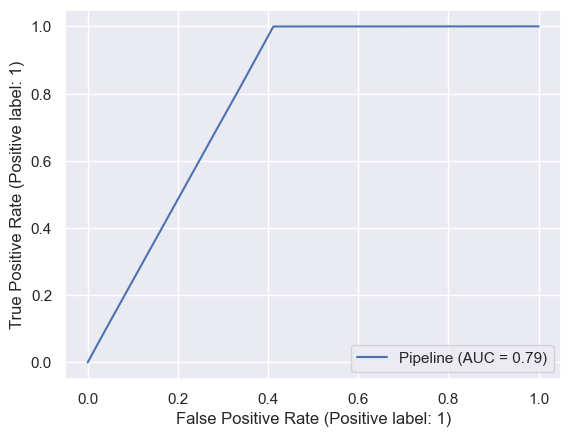

In [22]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type", "original_index", \
                                "upper","labels","longest_word","sld","longest_word selected",\
                                "sld selected"]]]
y = stateless_df["attack"]
trained_pipes_rf = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('scaler', StandardScaler(), [col for col in X_train])
    ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('rf', RandomForestClassifier(random_state=0))
    ])    
    pipe.fit(X_train, y_train)
    
    prediction_time_start = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    prediction_time_end = time.time()
    print(f"Total time elapsed for prediction: {(prediction_time_end - prediction_time_start):.2f}")
    total_prediction_time_stateless += (prediction_time_end - prediction_time_start)
    trained_pipes_rf.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    
rf_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    





In [23]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 94.904
Time to evaluate a single data point: 0.00012533


In [24]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999301,0.595930,0.746617,462858.000000
1,0.611322,0.999344,0.758594,294353.000000
accuracy,0.752751,0.752751,0.752751,0.752751
macro avg,0.805311,0.797637,0.752606,757211.000000
weighted avg,0.848480,0.752751,0.751273,757211.000000


## Rebuilding RF MODEL for Anova Feature Selection Technique

In [25]:
import glob
import numpy as np
import os
import time
import ast 
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report,RocCurveDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from statistics import mean
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve,auc, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
sns.set_theme()
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Feature Engineering for the second technique

In [26]:
enc = LabelEncoder()
catcol_stateful=['rr_type', 'distinct_ip', 'unique_country', 'unique_asn', 'distinct_domains', 'reverse_dns']
catcol_stateless=['longest_word', 'sld', ]

indexsf = pd.Index(stateful_df['attack'])
print("stateful::\n",indexsf.value_counts())
indexsl = pd.Index(stateless_df['attack'])
print("stateless::\n",indexsl.value_counts())

for cols in catcol_stateful:
    stateful_df[cols] = enc.fit_transform(stateful_df[cols].astype(str))
for cols in catcol_stateless:
    stateless_df[cols] = enc.fit_transform(stateless_df[cols].astype(str))
X_stateful=stateful_df.drop(columns=['unique_ttl','attack','original_index','data_type','origin'],axis=1)
X_stateless=stateless_df.drop(columns=['attack','timestamp','original_index','data_type','origin'],axis=1)
y_stateful=stateful_df['attack']
y_stateless=stateless_df['attack']
y_stateful=y_stateful.to_frame()
y_stateless=y_stateless.to_frame()

mmsc=MinMaxScaler(feature_range=(0, 1))

X_stateless_scaled=mmsc.fit_transform(X_stateless)
X_stateless_scaled_df=pd.DataFrame(X_stateless_scaled,columns = X_stateless.columns)

X_stateful_scaled=mmsc.fit_transform(X_stateful)
X_stateful_scaled_df=pd.DataFrame(X_stateful_scaled,columns = X_stateful.columns)

s = SelectKBest(f_classif, k=10)
s.fit(X_stateful_scaled_df, y_stateful)
cols = s.get_support(indices=True)
features_df_new = X_stateful_scaled_df.iloc[:,cols]
print(features_df_new.columns)

s = SelectKBest(f_classif, k=8)
s.fit(X_stateless_scaled_df, y_stateless)
cols = s.get_support(indices=True)
features_df_new = X_stateless_scaled_df.iloc[:,cols]
print(features_df_new.columns)



stateful::
 0    178782
1     83323
Name: attack, dtype: int64
stateless::
 0    462858
1    294353
Name: attack, dtype: int64
Index(['rr', 'A_frequency', 'PTR_frequency', 'rr_type', 'rr_count',
       'rr_name_entropy', 'rr_name_length', 'distinct_ns', 'ttl_mean',
       'Predictions'],
      dtype='object')
Index(['FQDN_count', 'subdomain_length', 'numeric', 'special', 'labels',
       'longest_word', 'sld', 'Predictions'],
      dtype='object')


Training time elapsed: 115.50
Train Accuracy: 0.75304406967684
Test Accuracy: 0.7526924321361832
Time elapsed: 22.24
Training time elapsed: 118.76
Train Accuracy: 0.7570592090384288
Test Accuracy: 0.7367308936754665
Time elapsed: 22.81
Training time elapsed: 119.39
Train Accuracy: 0.7505980002278096
Test Accuracy: 0.7625229460783667
Time elapsed: 22.03
Training time elapsed: 131.55
Train Accuracy: 0.75024803184052
Test Accuracy: 0.763962441066547
Time elapsed: 23.57
Training time elapsed: 112.58
Train Accuracy: 0.7541637158718918
Test Accuracy: 0.7482864727090239
Time elapsed: 29.75


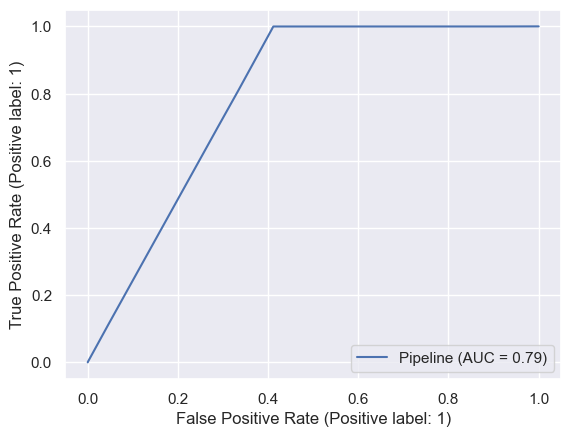

Total time elapsed for predictions: 120.40


In [27]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type","lower", "original_index","upper","labels_max","labels_average"]]]
    
y = stateless_df["attack"]
trained_pipes_rf = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
         ('rf', RandomForestClassifier(random_state=0))
    ])    
    time_train_start = time.time()

    pipe.fit(X_train, y_train)
    
    time_train_end = time.time()
    
    print(f"Training time elapsed: {(time_train_end - time_train_start):.2f}")

    start_fold = time.time()
    X_test = category_pipeline.transform(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    end_fold = time.time()
    print(f"Time elapsed: {(end_fold - start_fold):.2f}")
    total_prediction_time_stateless += (end_fold - start_fold)
    
    trained_pipes_rf.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)
rf_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show() 

print(f"Total time elapsed for predictions: {(total_prediction_time_stateless):.2f}")


In [28]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 120.396
Time to evaluate a single data point: 0.00015900


In [29]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999457,0.595982,0.746701,462858.000000
1,0.611387,0.999490,0.758686,294353.000000
accuracy,0.752839,0.752839,0.752839,0.752839
macro avg,0.805422,0.797736,0.752694,757211.000000
weighted avg,0.848601,0.752839,0.751360,757211.000000


## This shows that the although both the feature selections improve accuracy from the base model, anova feature selection gives us slightly better results as the AUROC goes upto 0.81 in one of the stratified folds. Prediction time for this model is also lesser as compared to the model with features selected by RFE

## ----------------xxxxxxxxxxxxxxxxxxxxxxxx----------------------------------------------